# makemore

makemore is a character generation engine that takes a text document as input, interprets each line in the text document as an example, and tries to make more text that is similar to those lines.

For the purposes of this notebook, makemore will receive a text block of about 32K line-separated (first) names, and try to generate more names.

## Needed Libraries

All libraries necessary for this notebook will be imported here.

In [1]:
import requests
import torch
from string import ascii_lowercase
import matplotlib.pyplot as plt

## Getting the Data

In [2]:
# get list of words
words = requests.get(
    "https://raw.githubusercontent.com/karpathy/makemore/master/names.txt"
    ).text.splitlines()

In [3]:
# test
words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [4]:
# some data
print('Total Words: ', len(words))
print('Length of shortest word: ', min(len(word) for word in words))
print('Length of longest word: ', max(len(word) for word in words))

Total Words:  32033
Length of shortest word:  2
Length of longest word:  15


## Understanding Bigrams

A bigram language model tries to predict the next character from the previous character only.

In [5]:
# print bigrams in first word in words
for word in words[:1]:
    for char1, char2 in zip(word, word[1:]):
        print(char1, char2)

e m
m m
m a


The model will need to understand what characters are most likely to start a name, and what characters are likely to end a name. We will need to include (invisible) starting and ending characters in each of our words.

In [6]:
# print word bigrams with start and end
for word in words[:3]:
    chars = ['<S>'] + list(word) + ['<E>']
    for char1, char2 in zip(chars, chars[1:]):
        print(char1, char2)

<S> e
e m
m m
m a
a <E>
<S> o
o l
l i
i v
v i
i a
a <E>
<S> a
a v
v a
a <E>


The simplest way for the model to understand the most likely character to predict is to first count the bigrams.

In [7]:
# print count of word bigrams for first 3 words
bigram_counts = {}
for word in words[:3]:
    chars = ['<S>'] + list(word) + ['<E>']
    for char1, char2 in zip(chars, chars[1:]):
        bigram = (char1, char2)
        bigram_counts[bigram] = bigram_counts.get(bigram, 0) + 1
for bigr, count in bigram_counts.items():
    print(bigr,":", count)

('<S>', 'e') : 1
('e', 'm') : 1
('m', 'm') : 1
('m', 'a') : 1
('a', '<E>') : 3
('<S>', 'o') : 1
('o', 'l') : 1
('l', 'i') : 1
('i', 'v') : 1
('v', 'i') : 1
('i', 'a') : 1
('<S>', 'a') : 1
('a', 'v') : 1
('v', 'a') : 1


In [8]:
# count of word bigrams for all words
bigram_counts = {}
for word in words:
    chars = ['<S>'] + list(word) + ['<E>']
    for char1, char2 in zip(chars, chars[1:]):
        bigram = (char1, char2)
        bigram_counts[bigram] = bigram_counts.get(bigram, 0) + 1

In [9]:
# 5 most common bigrams
bigrams_counts_sorted = sorted(
    bigram_counts.items(),
    key=lambda x: x[1],
    reverse=True
)
for k, v in bigrams_counts_sorted[:5]:
    print(f"{k}: {v}")

('n', '<E>'): 6763
('a', '<E>'): 6640
('a', 'n'): 5438
('<S>', 'a'): 4410
('e', '<E>'): 3983


As we continue, we won't need to keep track of an explicit "Start" and "End" character because there's no need to differentiate them (a "Start" character will never appear at the end of the word). Rather, we can have a single character which represents both the beginning and end of a word.

In [10]:
# counts, but with start and end characters replaced with period
bigram_counts = {}
for word in words:
    chars = ['.'] + list(word) + ['.']
    for char1, char2 in zip(chars, chars[1:]):
        bigram = (char1, char2)
        bigram_counts[bigram] = bigram_counts.get(bigram, 0) + 1
bigrams_counts_sorted = sorted(
    bigram_counts.items(),
    key=lambda x: x[1],
    reverse=True
)
for k, v in bigrams_counts_sorted[:5]:
    print(f"{k}: {v}")

('n', '.'): 6763
('a', '.'): 6640
('a', 'n'): 5438
('.', 'a'): 4410
('e', '.'): 3983


## Bigram Tensor

A better way (conducive to understanding, and to building a model) to store our bigrams and counts is with a 2D array. The rows in the array will be the first character in the bigram, and the columns will be the second character.

PyTorch is useful for the efficient manipulation of arrays, so we're using that.

In [11]:
# example tensor
a = torch.zeros((3, 5))
# notice dtype
print(a.dtype)

torch.float32


The default datatype in PyTorch is single-point float. Since we're using integers to store our counts, let's make ints our default.

In [12]:
# initialize array
N = torch.zeros((27, 27), dtype=torch.int32)

In [13]:
# map characters to integers for array lookup
char_list = ['.'] + list(ascii_lowercase)
stoi = {s:i for i, s in enumerate(char_list)}

In [14]:
# store bigram counts in array
for word in words:
    chars = ['.'] + list(word) + ['.']
    for char1, char2 in zip(chars, chars[1:]):
        idx1 = stoi[char1]
        idx2 = stoi[char2]
        N[idx1, idx2] += 1

In [15]:
# reverse character-mapping for visualization
itos = {i:s for i, s in enumerate(char_list)}

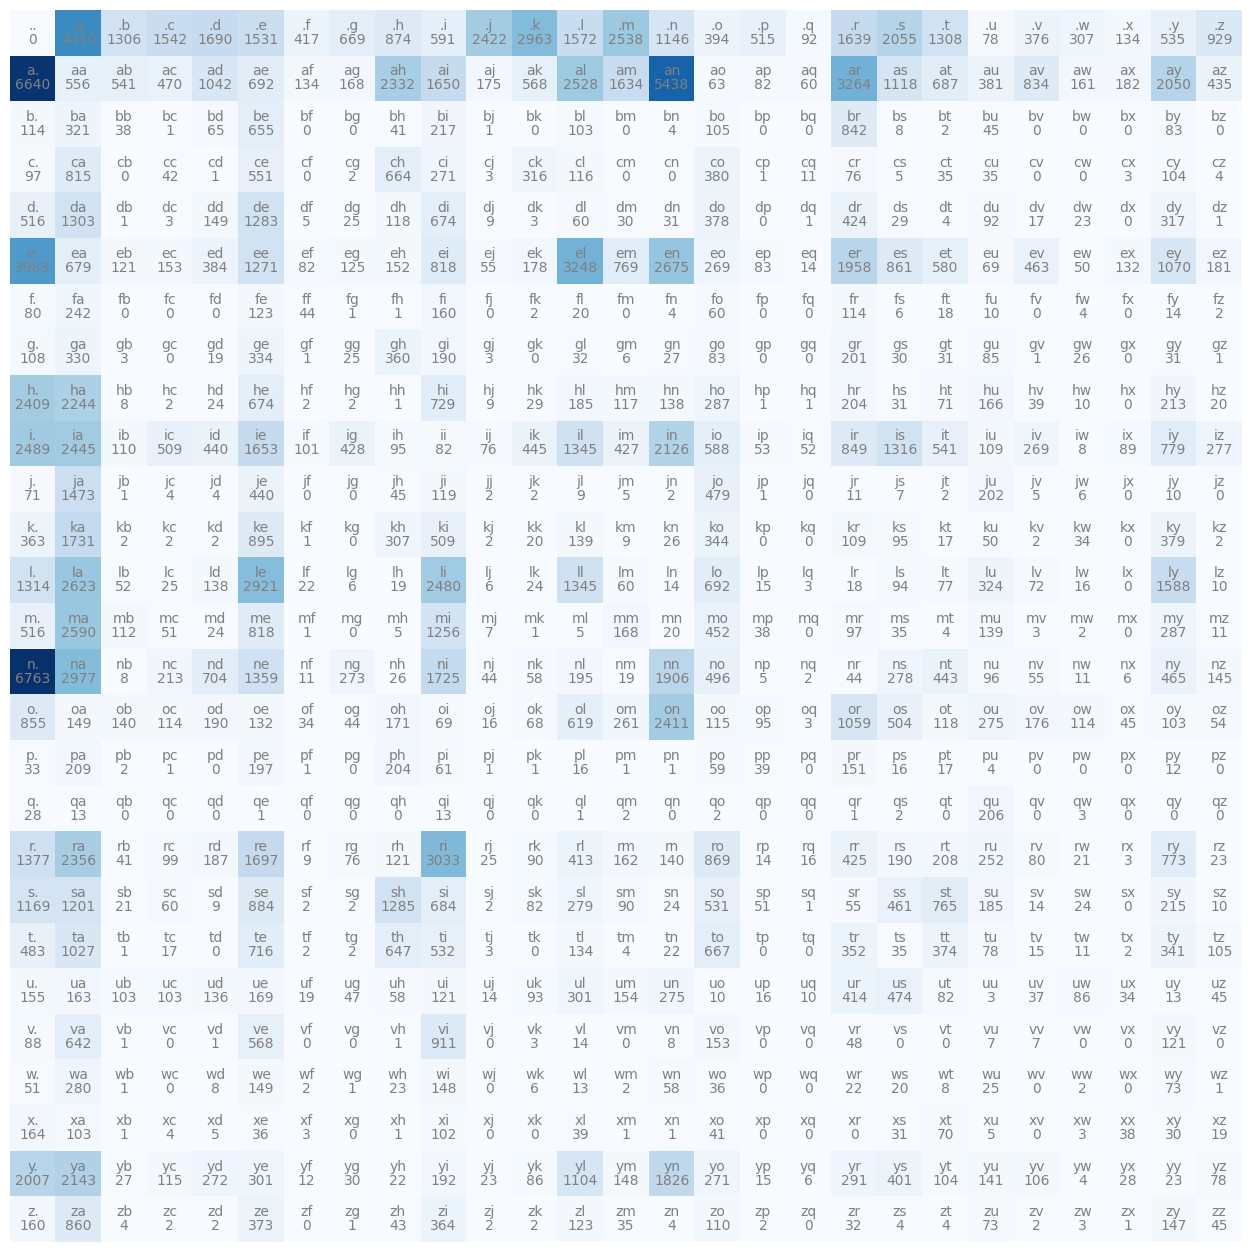

In [16]:
# visualize bigram counts
plt.figure(figsize=(16, 16))
plt.imshow(N, cmap='Blues')
for i in range(27):
    for j in range(27):
        bigram = itos[i] + itos[j]
        plt.text(j, i, bigram, ha='center', va='bottom', color='gray')
        plt.text(j, i, N[i, j].item(), ha='center', va='top', color='gray')
plt.axis('off');

## Converting Counts to Probabilities

In [17]:
# get first row tensor
N[0]

tensor([   0, 4410, 1306, 1542, 1690, 1531,  417,  669,  874,  591, 2422, 2963,
        1572, 2538, 1146,  394,  515,   92, 1639, 2055, 1308,   78,  376,  307,
         134,  535,  929], dtype=torch.int32)

In [18]:
# normalize
row1_probs = torch.nn.functional.normalize(N[0].float(), p=1, dim=0)
print("probabilities:", row1_probs)
print("sum (to 1):", row1_probs.sum())

probabilities: tensor([0.0000, 0.1377, 0.0408, 0.0481, 0.0528, 0.0478, 0.0130, 0.0209, 0.0273,
        0.0184, 0.0756, 0.0925, 0.0491, 0.0792, 0.0358, 0.0123, 0.0161, 0.0029,
        0.0512, 0.0642, 0.0408, 0.0024, 0.0117, 0.0096, 0.0042, 0.0167, 0.0290])
sum (to 1): tensor(1.)


In [19]:
# generator for "reproduceable randomness"
gen = torch.Generator().manual_seed(2147483647)

In [20]:
# get starting letter sample
idx = torch.multinomial(row1_probs, num_samples=1, replacement=True, generator=gen).item()
print(itos[idx])

j


In [21]:
# first test round

gen = torch.Generator().manual_seed(2147483647)

for i in range(10):

    out = []
    idx = 0
    while True:
        array_row = N[idx].float()
        char_probs = torch.nn.functional.normalize(array_row, p=1, dim=0)
        idx = torch.multinomial(char_probs, num_samples=1, replacement=True, generator=gen).item()
        out.append(itos[idx])
        if idx == 0:
            break
    print(''.join(out))

junide.
janasah.
p.
cony.
a.
nn.
kohin.
tolian.
juee.
ksahnaauranilevias.


In [22]:
# normalize array by row
P = torch.nn.functional.normalize(N.float(), p=1, dim=1)

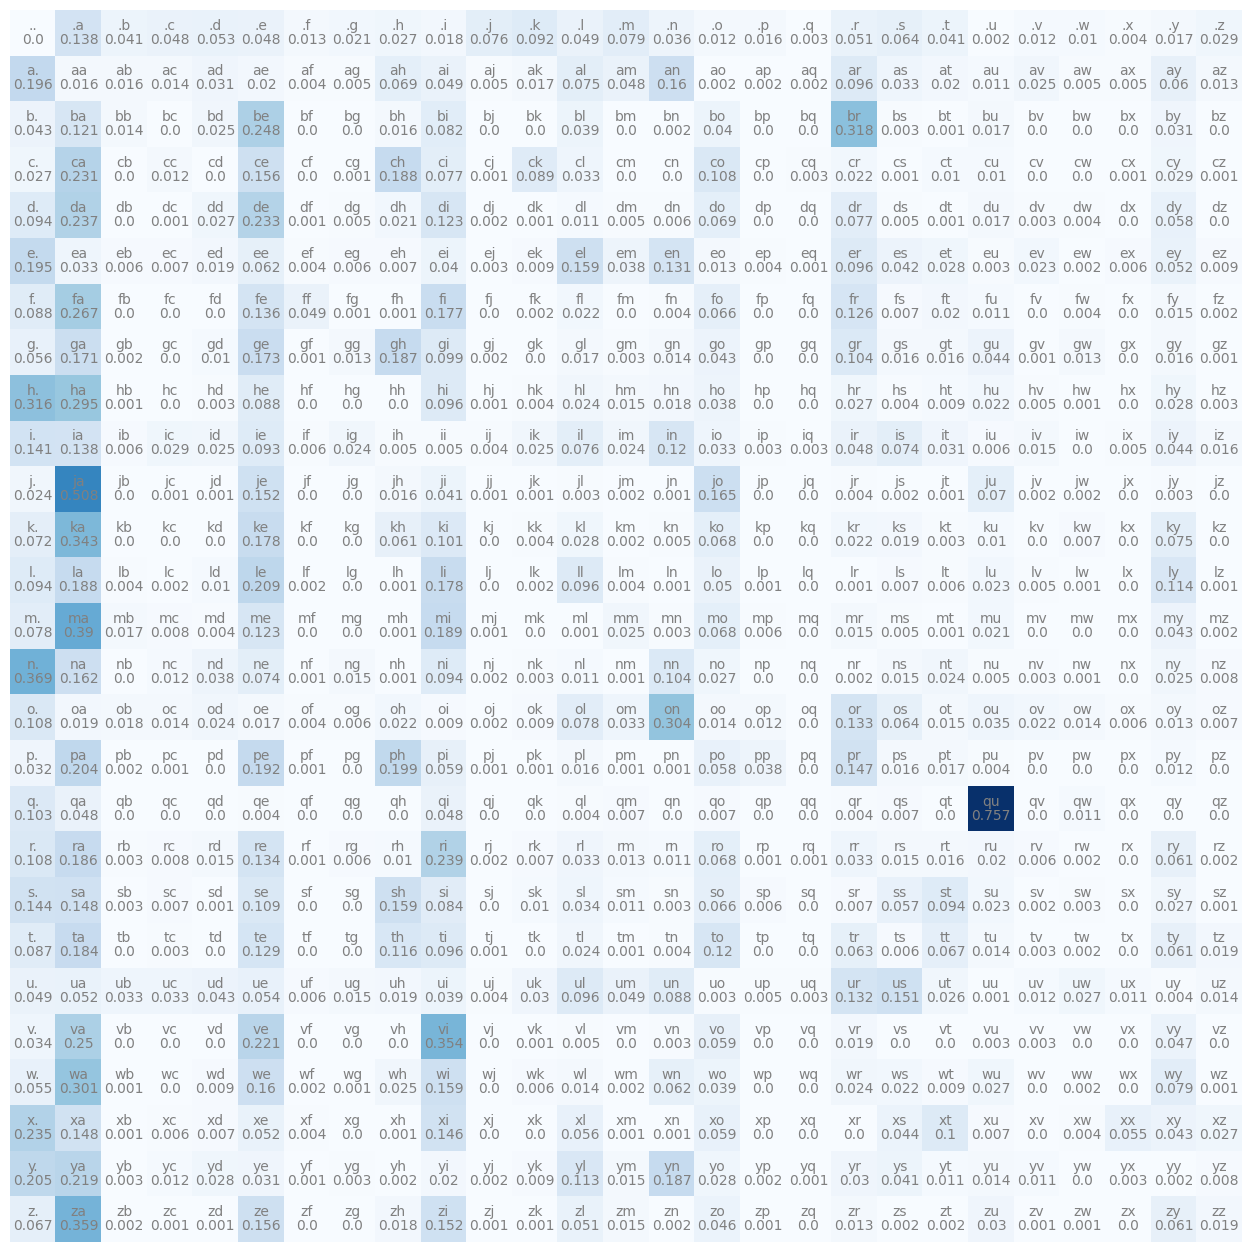

In [23]:
# visualize bigram probabilities normalized by row
plt.figure(figsize=(16, 16))
plt.imshow(P, cmap='Blues')
for i in range(27):
    for j in range(27):
        bigram = itos[i] + itos[j]
        plt.text(j, i, bigram, ha='center', va='bottom', color='gray')
        plt.text(j, i, round(P[i, j].item(), 3), ha='center', va='top', color='gray')
plt.axis('off');

In [24]:
# test round using normalized bigram array

gen = torch.Generator().manual_seed(2147483647)

for i in range(10):

    out = []
    idx = 0
    while True:
        char_probs = P[idx]
        # array_row = N[idx].float()
        # char_probs = torch.nn.functional.normalize(array_row, p=1, dim=0)
        idx = torch.multinomial(char_probs, num_samples=1, replacement=True, generator=gen).item()
        out.append(itos[idx])
        if idx == 0:
            break
    print(''.join(out))

junide.
janasah.
p.
cony.
a.
nn.
kohin.
tolian.
juee.
ksahnaauranilevias.


## Loss Function

We need a way to measure the effectiveness of the model. Since we have probabilities, we want our model to maximize the probability of the "correct" next character to predict.

In [25]:
# get probabilities for bigrams in first 3 words
for word in words[:3]:
    chars = ['.'] + list(word) + ['.']
    for char1, char2 in zip(chars, chars[1:]):
        idx1 = stoi[char1]
        idx2 = stoi[char2]
        prob = P[idx1, idx2]
        print(f"{char1}{char2}: {prob:.4f}")

.e: 0.0478
em: 0.0377
mm: 0.0253
ma: 0.3899
a.: 0.1960
.o: 0.0123
ol: 0.0780
li: 0.1777
iv: 0.0152
vi: 0.3541
ia: 0.1381
a.: 0.1960
.a: 0.1377
av: 0.0246
va: 0.2495
a.: 0.1960


Again, since we're dealing with probabilities, a measure of success would be increasing the "likelihood", which is the "correct" probabilities multiplied together. To multiply all of our current probabilities would yield a very small number, so let's use the log probability instead.

In [26]:
# get log probabilities for bigrams in first 3 words
for word in words[:3]:
    chars = ['.'] + list(word) + ['.']
    for char1, char2 in zip(chars, chars[1:]):
        idx1 = stoi[char1]
        idx2 = stoi[char2]
        prob = P[idx1, idx2]
        logprob = torch.log(prob)
        print(f"{char1}{char2}: {prob:.4f} {logprob:.4f}")

.e: 0.0478 -3.0408
em: 0.0377 -3.2793
mm: 0.0253 -3.6772
ma: 0.3899 -0.9418
a.: 0.1960 -1.6299
.o: 0.0123 -4.3982
ol: 0.0780 -2.5508
li: 0.1777 -1.7278
iv: 0.0152 -4.1867
vi: 0.3541 -1.0383
ia: 0.1381 -1.9796
a.: 0.1960 -1.6299
.a: 0.1377 -1.9829
av: 0.0246 -3.7045
va: 0.2495 -1.3882
a.: 0.1960 -1.6299


Now from log probability, we get the log likelihood.

In [27]:
# get log likelihood for model
log_likelihood = 0.0
for word in words[:3]:
    chars = ['.'] + list(word) + ['.']
    for char1, char2 in zip(chars, chars[1:]):
        idx1 = stoi[char1]
        idx2 = stoi[char2]
        prob = P[idx1, idx2]
        logprob = torch.log(prob)
        log_likelihood += logprob
        print(f"{char1}{char2}: {prob:.4f} {logprob:.4f}")

print(f"{log_likelihood=}")

.e: 0.0478 -3.0408
em: 0.0377 -3.2793
mm: 0.0253 -3.6772
ma: 0.3899 -0.9418
a.: 0.1960 -1.6299
.o: 0.0123 -4.3982
ol: 0.0780 -2.5508
li: 0.1777 -1.7278
iv: 0.0152 -4.1867
vi: 0.3541 -1.0383
ia: 0.1381 -1.9796
a.: 0.1960 -1.6299
.a: 0.1377 -1.9829
av: 0.0246 -3.7045
va: 0.2495 -1.3882
a.: 0.1960 -1.6299
log_likelihood=tensor(-38.7856)


log likelihood will reach a maximum of zero. Since we're dealing with a loss function, where we want to *reduce* the size of the output value, we will negate this value (the negative log likelihood).

In [28]:
# negative log likelihood
nll = -log_likelihood
print(f"{nll=}")

nll=tensor(38.7856)


The last change to make is to make an average of the losses, rather than a sum. This will tell us how our model does on average, not overall.

In [29]:
# get average negative log likelihood (loss function)
log_likelihood = 0.0
count = 0
for word in words[:3]:
    chars = ['.'] + list(word) + ['.']
    for char1, char2 in zip(chars, chars[1:]):
        idx1 = stoi[char1]
        idx2 = stoi[char2]
        prob = P[idx1, idx2]
        logprob = torch.log(prob)
        log_likelihood += logprob
        count += 1
        print(f"{char1}{char2}: {prob:.4f} {logprob:.4f}")
nll = -log_likelihood
anll = nll / count

print(f"{nll=}")
print(f"{anll=}")

.e: 0.0478 -3.0408
em: 0.0377 -3.2793
mm: 0.0253 -3.6772
ma: 0.3899 -0.9418
a.: 0.1960 -1.6299
.o: 0.0123 -4.3982
ol: 0.0780 -2.5508
li: 0.1777 -1.7278
iv: 0.0152 -4.1867
vi: 0.3541 -1.0383
ia: 0.1381 -1.9796
a.: 0.1960 -1.6299
.a: 0.1377 -1.9829
av: 0.0246 -3.7045
va: 0.2495 -1.3882
a.: 0.1960 -1.6299
nll=tensor(38.7856)
anll=tensor(2.4241)


In [30]:
# wrapping for ease of use
def score_words(word_list):
    log_likelihood = 0.0
    count = 0
    for word in word_list:
        chars = ['.'] + list(word) + ['.']
        for char1, char2 in zip(chars, chars[1:]):
            idx1 = stoi[char1]
            idx2 = stoi[char2]
            prob = P[idx1, idx2]
            logprob = torch.log(prob)
            log_likelihood += logprob
            count += 1
            print(f"{char1}{char2}: {prob:.4f} {logprob:.4f}")
    nll = -log_likelihood
    anll = nll / count

    print(f"{nll=}")
    print(f"{anll=}")

In [31]:
# testing
score_words(["austin"])

.a: 0.1377 -1.9829
au: 0.0112 -4.4879
us: 0.1512 -1.8892
st: 0.0944 -2.3605
ti: 0.0955 -2.3485
in: 0.1201 -2.1194
n.: 0.3690 -0.9969
nll=tensor(16.1853)
anll=tensor(2.3122)


In [32]:
# testing
score_words(['andrej'])

.a: 0.1377 -1.9829
an: 0.1605 -1.8296
nd: 0.0384 -3.2594
dr: 0.0771 -2.5620
re: 0.1336 -2.0127
ej: 0.0027 -5.9171
j.: 0.0245 -3.7098
nll=tensor(21.2735)
anll=tensor(3.0391)


In [33]:
# testing
score_words(['ausqtin'])

.a: 0.1377 -1.9829
au: 0.0112 -4.4879
us: 0.1512 -1.8892
sq: 0.0001 -9.0004
qt: 0.0000 -inf
ti: 0.0955 -2.3485
in: 0.1201 -2.1194
n.: 0.3690 -0.9969
nll=tensor(inf)
anll=tensor(inf)


Negative infinity won't work. We need to introduce a level of smoothing into our probabilities that will prevent the appearance of infinities in our loss function.

In [34]:
# smoothing probability array
P = torch.nn.functional.normalize((N+1).float(), p=1, dim=1)

In [35]:
# testing score_words again
score_words(['ausqtin'])

.a: 0.1376 -1.9835
au: 0.0113 -4.4861
us: 0.1502 -1.8956
sq: 0.0002 -8.3105
qt: 0.0033 -5.7004
ti: 0.0952 -2.3515
in: 0.1200 -2.1204
n.: 0.3685 -0.9982
nll=tensor(27.8464)
anll=tensor(3.4808)


## Neural Network Approach, Part 1: Preparing Inputs

In [36]:
# prepare function to create training set of bigrams (x,y)
def get_bigram_tensors(word_list):
    xs, ys = [], []

    for word in word_list:
        chars = ['.'] + list(word) + ['.']
        for char1, char2 in zip(chars, chars[1:]):
            idx1 = stoi[char1]
            idx2 = stoi[char2]
            xs.append(idx1)
            ys.append(idx2)

    x = torch.tensor(xs)
    y = torch.tensor(ys)

    return x, y

In [37]:
# training set for "emma"
emma_tensor_x, emma_tensor_y = get_bigram_tensors(words[:1])
print(emma_tensor_x)
print(emma_tensor_y)

tensor([ 0,  5, 13, 13,  1])
tensor([ 5, 13, 13,  1,  0])


A word of caution about tensor types:
- torch.tensor() infers the dtype automatically.
- torch.Tensor() returns a TensorFloat type.

In [38]:
emma_tensor_x.dtype

torch.int64

It doesn't make sense to pass in integer types into our neural network, and perform mathematical operations on that integer. Let's one-hot-encode our integers, so that our weights are applied to a normalized set of values.

tensor([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0]]) 

torch.Size([5, 27]) 

torch.int64 



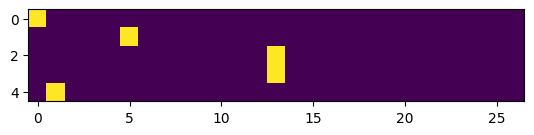

In [46]:
# one hot encoding "emma" tensor
xenc = torch.nn.functional.one_hot(emma_tensor_x, num_classes=27)
print(xenc, '\n')
print(xenc.shape, '\n')
print(xenc.dtype, '\n')
plt.imshow(xenc);

We will need to cast our one-hots to floats. Unfortunately, functional.one_hot() does not support casting.

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.]]) 

torch.Size([5, 27]) 

torch.float32 



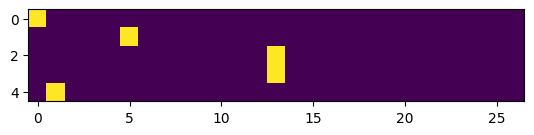

In [40]:
# one-hot encoding with floats
xenc = torch.nn.functional.one_hot(emma_tensor_x, num_classes=27).float()
print(xenc, '\n')
print(xenc.shape, '\n')
print(xenc.dtype, '\n')
plt.imshow(xenc);

## Neural Network Approach, Part 2: Constructing the Neural Net

In [41]:
# randomizing weights
# 27 weights for 1 neuron
W = torch.randn((27, 1), generator=gen)
print(W)

tensor([[ 0.9374],
        [-0.8830],
        [ 1.7457],
        [ 2.1346],
        [-0.8561],
        [ 0.5408],
        [ 0.6169],
        [ 1.5160],
        [-1.0447],
        [-0.6641],
        [-0.7239],
        [-0.3639],
        [ 0.0948],
        [-1.1645],
        [ 1.8010],
        [ 0.4707],
        [-0.8746],
        [-0.2977],
        [-1.3707],
        [ 1.0894],
        [-0.1801],
        [ 1.3034],
        [-1.1887],
        [ 0.8047],
        [-1.7149],
        [-0.3379],
        [-1.8263]])


In [42]:
# matrix multiplication
print(xenc.shape)
print(W.shape)
xW = xenc @ W
print(xW.shape, '\n')
print(xW)

torch.Size([5, 27])
torch.Size([27, 1])
torch.Size([5, 1]) 

tensor([[ 0.9374],
        [ 0.5408],
        [-1.1645],
        [-1.1645],
        [-0.8830]])


The values in this tensor tell us:
- The firing rate of 1 neuron (_, 1)
- For each of 5 examples (5, _)

We will want a set of neurons that output a firing probability for each letter of our character set for any input. So, we need 27 neurons.

In [43]:
# getting neuron firing rates by example
W = torch.randn((27, 27), generator=gen)
print(xenc.shape)
print(W.shape)
xW = xenc @ W
print(xW.shape, '\n')
print(xW)

torch.Size([5, 27])
torch.Size([27, 27])
torch.Size([5, 27]) 

tensor([[ 1.3504,  1.3348,  0.4985,  0.2072, -0.7866,  0.1755, -2.2901, -0.7093,
         -1.0632, -0.6060,  0.9178, -1.2320, -0.3952, -0.5614, -0.1375, -0.1380,
          1.5222,  0.4391,  0.1693,  0.2035, -0.1894,  0.5642,  0.9684, -0.3111,
         -0.5351, -1.1953, -0.7016],
        [-1.6086,  0.0432, -0.7226,  0.5205,  0.7270,  0.1114, -0.5977, -0.3977,
         -1.2801, -1.0094, -0.1463, -0.5254, -1.5195,  0.3240, -1.5065,  1.2898,
         -1.5100,  0.2446,  0.0549,  1.3537, -1.0896,  0.2558,  0.2469,  0.3190,
         -0.9861, -1.7323, -3.0010],
        [-0.9668,  0.0875,  0.8542,  0.1788, -0.4164, -1.4132, -0.4256,  0.5955,
         -1.0887, -0.9077, -0.4524, -0.9885,  1.4561, -0.0798, -1.1583, -1.2844,
          1.0193,  0.3248,  0.6420, -0.7851, -0.8293, -1.4605, -0.7034, -0.7133,
          0.9976,  0.6403, -0.8643],
        [-0.9668,  0.0875,  0.8542,  0.1788, -0.4164, -1.4132, -0.4256,  0.5955,
         -1.0887

## Neural Network Approach, Part 3: Softmax

We have the firing rates for each example, but they're not probabilities. Let's first convert them into only-positive log-counts by exponentiating them, then normalize them to get probabilities.

In [44]:
# convert to log-counts
logits = xW
counts = logits.exp() # neural network's version of N matrix
print(counts)

tensor([[ 3.8591,  3.7991,  1.6462,  1.2303,  0.4554,  1.1918,  0.1013,  0.4920,
          0.3454,  0.5456,  2.5037,  0.2917,  0.6735,  0.5704,  0.8715,  0.8711,
          4.5822,  1.5512,  1.1845,  1.2257,  0.8274,  1.7581,  2.6337,  0.7326,
          0.5856,  0.3026,  0.4958],
        [ 0.2002,  1.0441,  0.4855,  1.6829,  2.0690,  1.1178,  0.5501,  0.6719,
          0.2780,  0.3644,  0.8639,  0.5913,  0.2188,  1.3827,  0.2217,  3.6322,
          0.2209,  1.2771,  1.0564,  3.8718,  0.3364,  1.2914,  1.2800,  1.3757,
          0.3730,  0.1769,  0.0497],
        [ 0.3803,  1.0914,  2.3496,  1.1957,  0.6594,  0.2434,  0.6534,  1.8139,
          0.3366,  0.4035,  0.6361,  0.3721,  4.2891,  0.9233,  0.3140,  0.2768,
          2.7712,  1.3838,  1.9004,  0.4561,  0.4363,  0.2321,  0.4949,  0.4900,
          2.7118,  1.8970,  0.4214],
        [ 0.3803,  1.0914,  2.3496,  1.1957,  0.6594,  0.2434,  0.6534,  1.8139,
          0.3366,  0.4035,  0.6361,  0.3721,  4.2891,  0.9233,  0.3140,  0.2768

In [45]:
# convert to probabilities by example
probs = torch.nn.functional.normalize(counts, p=1, dim=1)
print(probs, '\n')
print(probs[0].sum())

tensor([[0.1092, 0.1075, 0.0466, 0.0348, 0.0129, 0.0337, 0.0029, 0.0139, 0.0098,
         0.0154, 0.0709, 0.0083, 0.0191, 0.0161, 0.0247, 0.0247, 0.1297, 0.0439,
         0.0335, 0.0347, 0.0234, 0.0498, 0.0746, 0.0207, 0.0166, 0.0086, 0.0140],
        [0.0075, 0.0391, 0.0182, 0.0631, 0.0775, 0.0419, 0.0206, 0.0252, 0.0104,
         0.0137, 0.0324, 0.0222, 0.0082, 0.0518, 0.0083, 0.1361, 0.0083, 0.0479,
         0.0396, 0.1451, 0.0126, 0.0484, 0.0480, 0.0516, 0.0140, 0.0066, 0.0019],
        [0.0131, 0.0375, 0.0806, 0.0410, 0.0226, 0.0084, 0.0224, 0.0623, 0.0116,
         0.0138, 0.0218, 0.0128, 0.1472, 0.0317, 0.0108, 0.0095, 0.0951, 0.0475,
         0.0652, 0.0157, 0.0150, 0.0080, 0.0170, 0.0168, 0.0931, 0.0651, 0.0145],
        [0.0131, 0.0375, 0.0806, 0.0410, 0.0226, 0.0084, 0.0224, 0.0623, 0.0116,
         0.0138, 0.0218, 0.0128, 0.1472, 0.0317, 0.0108, 0.0095, 0.0951, 0.0475,
         0.0652, 0.0157, 0.0150, 0.0080, 0.0170, 0.0168, 0.0931, 0.0651, 0.0145],
        [0.0985, 0.1535,

In [47]:
probs.shape

torch.Size([5, 27])

Now we have a set of probabilities, but we need a way to measure the accuracy of the probabilities against the training data: the loss function.

## Summary

In [50]:
# integer representations (alphabet index) of input and prediction target
print(emma_tensor_x)
print(emma_tensor_y)
# randomly generate weights for 27 neurons with 27 inputs
W = torch.randn((27, 27), generator=gen)
# one-hot encoding of input
xenc = torch.nn.functional.one_hot(emma_tensor_x, num_classes=27).float()
print(xenc.shape)
print(W.shape)
# log-counts, exponentiate & normalize for softmax
logits = xenc @ W
print(logits.shape)
print(logits[0])
counts = logits.exp()
print(counts[0])
probs = torch.nn.functional.normalize(counts, p=1, dim=1)
print(probs)

tensor([ 0,  5, 13, 13,  1])
tensor([ 5, 13, 13,  1,  0])
torch.Size([5, 27])
torch.Size([27, 27])
torch.Size([5, 27])
tensor([ 0.1896, -0.5003, -1.8337,  0.2345, -1.4810,  0.3462,  2.2822,  0.3083,
         0.1332,  0.4263, -1.0455, -0.5421,  0.1443, -0.9925, -0.4937,  0.4813,
         0.3000,  0.9846,  0.2691,  0.0566, -0.9745,  0.5490,  0.5698, -0.3403,
         0.3398,  0.3698, -0.1971])
tensor([1.2088, 0.6064, 0.1598, 1.2642, 0.2274, 1.4137, 9.7981, 1.3611, 1.1424,
        1.5316, 0.3515, 0.5815, 1.1553, 0.3706, 0.6103, 1.6182, 1.3499, 2.6767,
        1.3088, 1.0583, 0.3774, 1.7315, 1.7679, 0.7115, 1.4046, 1.4474, 0.8211])
tensor([[0.0318, 0.0159, 0.0042, 0.0332, 0.0060, 0.0371, 0.2575, 0.0358, 0.0300,
         0.0402, 0.0092, 0.0153, 0.0304, 0.0097, 0.0160, 0.0425, 0.0355, 0.0703,
         0.0344, 0.0278, 0.0099, 0.0455, 0.0465, 0.0187, 0.0369, 0.0380, 0.0216],
        [0.0575, 0.0473, 0.0340, 0.0865, 0.0170, 0.1978, 0.0067, 0.0286, 0.0274,
         0.0478, 0.0086, 0.0244, 0.0599

In [51]:
nlls = torch.zeros(5)
for i in range(5):
  # i-th bigram:
  x = emma_tensor_x[i].item() # input character index
  y = emma_tensor_y[i].item() # label character index
  print('--------')
  print(f'bigram example {i+1}: {itos[x]}{itos[y]} (indexes {x},{y})')
  print('input to the neural net:', x)
  print('output probabilities from the neural net:', probs[i])
  print('label (actual next character):', y)
  p = probs[i, y]
  print('probability assigned by the net to the the correct character:', p.item())
  logp = torch.log(p)
  print('log likelihood:', logp.item())
  nll = -logp
  print('negative log likelihood:', nll.item())
  nlls[i] = nll

print('=========')
print('average negative log likelihood, i.e. loss =', nlls.mean().item())

--------
bigram example 1: .e (indexes 0,5)
input to the neural net: 0
output probabilities from the neural net: tensor([0.0318, 0.0159, 0.0042, 0.0332, 0.0060, 0.0371, 0.2575, 0.0358, 0.0300,
        0.0402, 0.0092, 0.0153, 0.0304, 0.0097, 0.0160, 0.0425, 0.0355, 0.0703,
        0.0344, 0.0278, 0.0099, 0.0455, 0.0465, 0.0187, 0.0369, 0.0380, 0.0216])
label (actual next character): 5
probability assigned by the net to the the correct character: 0.03714814409613609
log likelihood: -3.2928414344787598
negative log likelihood: 3.2928414344787598
--------
bigram example 2: em (indexes 5,13)
input to the neural net: 5
output probabilities from the neural net: tensor([0.0575, 0.0473, 0.0340, 0.0865, 0.0170, 0.1978, 0.0067, 0.0286, 0.0274,
        0.0478, 0.0086, 0.0244, 0.0599, 0.0124, 0.0260, 0.0102, 0.0725, 0.0174,
        0.0379, 0.0192, 0.0087, 0.0257, 0.0085, 0.0262, 0.0307, 0.0367, 0.0245])
label (actual next character): 13
probability assigned by the net to the the correct character: 

## Neural Network Approach, Part 4: Loss Function

In [57]:
# probabilities for correct predictions
emma_probs = probs[torch.arange(5), emma_tensor_y]
# negative mean log likelihood (score)
loss = -emma_probs.log().mean()
print(loss)

tensor(3.7345)


## Neural Network Approach, Part 5: Backward Pass

In [59]:
# randomly initialize 27 neurons' weights. each neuron receives 27 inputs
g = torch.Generator().manual_seed(2147483647)
W = torch.randn((27, 27), generator=gen, requires_grad=True)

In [60]:
# forward pass
xenc = torch.nn.functional.one_hot(emma_tensor_x, num_classes=27).float() # input to the network: one-hot encoding
logits = xenc @ W # predict log-counts
counts = logits.exp() # counts, equivalent to N
probs = counts / counts.sum(1, keepdims=True) # probabilities for next character
loss = -probs[torch.arange(5), emma_tensor_y].log().mean()

In [61]:
# backward pass
W.grad = None # set to zero the gradient
loss.backward()